# VELA Clumpy Galaxy Classifier

According to [Mandelker et al. 2017](https://arxiv.org/pdf/1512.08791), a clumpy galaxy is a galaxy with at least one giant clump that:
- Has baryonic mass $\geq 1e7 M_{\odot}$
- The star formation rate (SFR) ratio between the clump and the galaxy (disc) satisfies $SFR_c/SFR_d>10^{-3}$
- Within a sphere of radius $R_d$

## 1. Utils

In [469]:
import os
import glob
import sys
import cv2
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.ops import box_iou, box_convert
from torch.utils.data import DataLoader

import astropy.units as u
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import MinMaxInterval, AsinhStretch, SinhStretch, LogStretch

import matplotlib.pyplot as plt

In [ ]:
# cams = [str(c).zfill(2) for c in np.arange(0,25)]
# scfctrs = [f'0.{a}' for a in range(100, 570, 10)]
# fltrs = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']

In [450]:
def seed_everything(seed=16512196):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [451]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar", print_msg=True):
    if print_msg:
        print(">> Saving checkpoint...")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    if print_msg:
        print("Done saving checkpoint.")

def load_checkpoint(checkpoint_file, model, optimizer, lr, device):
    print(">> Loading checkpoint...")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    print("Done loading checkpoint.\n")
    

In [519]:
cat_path = '/sci/home/omryg/astro-home/old-omryg-home/mycatalogs/npy/'

galaxy_cat = np.load(cat_path + 'galaxy_cat_new_g3.npy')
clump_cat = np.load(cat_path + 'clump_cat_g3.npy')

def get_fit_data(header):
    cam_z = np.array([header['CAMDIRX'],header['CAMDIRY'],header['CAMDIRZ']])
    cam_y = np.array([header['CAMUPX'],header['CAMUPY'],header['CAMUPZ']])
    cam_x = np.cross(cam_y, cam_z)
    
    npix = header['NAXIS1']
    pixscale = header['PIXKPC']

    npix_real = npix
    pixscale_real = pixscale
    
    return npix_real, pixscale_real, np.array([cam_x, cam_y, cam_z])

def get_sunrise_center(header):
    return header['translate_originX'], header['translate_originY'], header['translate_originZ']

def is_clumpy(galaxy, cam, scfctr, fltr='f200w'): 
        VELA_JWST_PATH = f'/sci/archive/dekel/lab_share/vela_jwst_mock/vela3_mocks/{fltr}/cam{cam}/jwst/nircam/{fltr}/'
        path = VELA_JWST_PATH + f'hlsp_vela_jwst_nircam_vela{galaxy}-cam{cam}-a{scfctr}_{fltr}_v3-2_sim-smc.fits'

        with fits.open(path) as hdul:
            header_sec = hdul[1].header
            header_sfrhist = hdul[6].header
            _,_,rotmat = get_fit_data(header_sec)
            
        shift = np.array(list(galaxy_cat[(galaxy_cat['galaxy'] == galaxy) & (galaxy_cat['a'] == scfctr)] \
                              [['center_x','center_y','center_z']][0])) \
                - get_sunrise_center(header_sfrhist)  
        Rd = galaxy_cat[(galaxy_cat['galaxy'] == galaxy) & (galaxy_cat['a'] == scfctr)]['Rd'][0]
        
        for clump in clump_cat[
            (clump_cat['galaxy'] == galaxy) & 
            (clump_cat['a'] == scfctr) &
            (clump_cat['lifetime'] != 'Bulg') & 
            (clump_cat['lifetime'] != 'ZLC') & 
            (clump_cat['Mbar'] >= 1e7) &
            (clump_cat['SFR'] / (clump_cat['disc_SFR'] + 1e-10) >= 1e-3)
        ]:
            pos = rotmat.dot(np.array(list(clump[['x','y','z']])) + shift)
            x, y =  pos[0], pos[1]
            if np.abs(x) > Rd or np.abs(y) > Rd:
                continue

            return True
        return False
    

## 2. Dataset

In [460]:
# ImageNet
# t = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224))
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# img = t(img)

# img = x.numpy() # np.random.random(size=(64, 64, 6))

# for i in range(6):
#     print(np.round(img[...,i].mean(), 8), np.round(img[...,i].std(), 8))

# img = (img - img.mean()) / img.std()
    
# print('\n')
# for i in range(6):
#     print(np.abs(np.round(img[...,i].mean(), 8)), np.round(img[...,i].std(), 8))

In [573]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, image_size, augment, transform, norm_each_channel, prot, pud, plr):
        
        self.image_size = image_size
        self.augment = augment
        self.transform = transform
        self.prot, self.pud, self.plr = prot, pud, plr
        
        # Norm each channel to mean 0 and std. 1
        self.norm_each_channel = norm_each_channel
        if self.norm_each_channel:
            self.mean = [0.041, 0.05, 0.06, 0.065, 0.073, 0.072]
            self.std = [0.08, 0.097, 0.112, 0.12, 0.127, 0.125]
            
        self.images_dir = images_dir
        image_files = sorted([f for f in glob.glob(f"{images_dir}/*.npy")])
        
        self.ids, self.images, self.labels = [], [], []
        pbar = tqdm(image_files, file=sys.stdout, colour='GREEN')
        for image_file in pbar:
            filename = image_file.split(os.sep)[-1][:-4]
            _, galaxy, cam, scfctr = filename.split('_')
            cam = cam[3:]
            scfctr = scfctr[1:]
            self.ids.append(f'vela{galaxy}_cam{cam}_a{scfctr}')  
            self.images.append(image_file)
            
            res = is_clumpy(galaxy, cam, scfctr)
            self.labels.append(1 if res else 0)
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image = np.load(self.images[idx])  # [...,0:3] # ONLY THE 3 BLUEST FILTERS
        label = self.labels[idx]
        filename = self.ids[idx]
        
        if self.augment:
            if np.random.random() < self.prot:
                n_rots = np.random.randint(low=1, high=5)
                for i in range(n_rots):
                    image = np.rot90(image)
            if np.random.random() < self.pud:
                image = np.flipud(image) 
            if np.random.random() < self.plr:
                image = np.fliplr(image)
                
        if image.shape[1] != self.image_size:
            image = cv2.resize(image, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        
        image = self.transform(image)
        
        if self.norm_each_channel:
            for channel in range(image.shape[2]):
                image[...,channel] = (image[...,channel] - self.mean[channel]) / self.std[channel]
       
        image = torch.from_numpy(image).permute(2, 0, 1)  # torch.from_numpy(image).unsqueeze(0) # 
        label = torch.tensor(label)
        
        return image, label, filename
        

### 2.1 Check dataset

In [528]:
path = '/sci/labs/dekel/oshri.fatkiev/vela3_6d_crop_64/images/test/vela3_21_cam17_a0.470.npy'
img = np.load(path)[...,0]
torch.tensor(img).unsqueeze(0).shape
# stretch = LogStretch()

# transform = stretch + MinMaxInterval()
# img = transform(img)

# plt.figure(figsize=(5, 5))
# plt.imshow(img[...,0], vmin=0, vmax=1)
# plt.show()

torch.Size([1, 64, 64])

In [574]:
transform = AsinhStretch() + MinMaxInterval()

dataset = Dataset(images_dir='/sci/labs/dekel/oshri.fatkiev/vela3_6d_crop_64/images/test/',
                  image_size=224, augment=True, transform=transform, norm_each_channel=False, prot=1, pud=0.5, plr=0.5)

dataLoader = DataLoader(dataset, batch_size=1, num_workers=4, shuffle=True) 

100%|██████████| 960/960 [00:05<00:00, 187.26it/s]


torch.Size([1, 6, 224, 224])


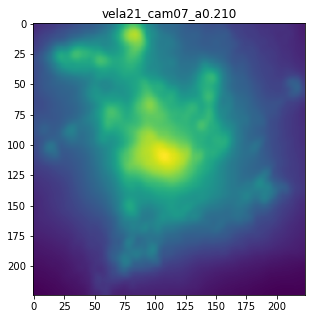

is_clumpy: True


In [575]:
x, y, name = next(iter(dataLoader))
print(x.shape)

plt.figure(figsize=(5, 5))
plt.imshow(x.squeeze(0)[0,...]) # [[1, 3, 5],...])
plt.title(name[0])
plt.show()

print(f'is_clumpy: {bool(y.item())}')

## 3. Model

In [576]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [595]:
from torchvision.models import vit_b_16, vit_b_32, vit_l_32, resnet18, resnet50

# model = vit_b_16(weights='DEFAULT')
# model.conv_proj = nn.Conv2d(6, 768, kernel_size=(16, 16), stride=(16, 16))
# model.heads.head = nn.Linear(in_features=768, out_features=1, bias=True))

model = vit_b_32(weights='DEFAULT')
model.conv_proj = nn.Conv2d(6, 768, kernel_size=(32, 32), stride=(32, 32))
model.heads.head = nn.Linear(in_features=768, out_features=1, bias=True)

# model = vit_l_32(weights='DEFAULT')
# model.conv_proj = nn.Conv2d(6, 1024, kernel_size=(32, 32), stride=(32, 32))
# model.heads.head = nn.Linear(in_features=1024, out_features=1, bias=True)

# model = resnet18(weights='DEFAULT')
# model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

# model = resnet50(weights='DEFAULT')
# model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

model.to(device)
print('Done')

Done


In [53]:
dinov2_vitb14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg_lc')

model = dinov2_vitb14_reg_lc
model.linear_head = torch.nn.Linear(in_features=3840, out_features=1, bias=True)

model.to(device)
print('Done')

Using cache found in /sci/home/oshri.fatkiev/.cache/torch/hub/facebookresearch_dinov2_main
/sci/home/oshri.fatkiev/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/sci/home/oshri.fatkiev/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/sci/home/oshri.fatkiev/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model: DINOv2


### 3.1 Check model

In [579]:
# Create a batch of random images with shape [batch_size, channels, height, width]
batch_size = 32
channels = 6

random_images = torch.randn(batch_size, channels, 224, 224).to(device)
output = model(random_images)

assert output.shape == torch.Size([batch_size, 1]),  f'Wrong output shape: {output.shape}'

## 4 Training

In [591]:
image_size = 224
batch_size = 64
num_workers = 4

transform = AsinhStretch() + MinMaxInterval()
# transform = LogStretch() + MinMaxInterval()

train_dir = '/sci/labs/dekel/oshri.fatkiev/vela3_6d_crop_64/images/train/'
train_dataset = Dataset(images_dir=train_dir, image_size=224, augment=True, transform=transform, 
                        norm_each_channel=False, prot=1, pud=0.5, plr=0.5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dir = '/sci/labs/dekel/oshri.fatkiev/vela3_6d_crop_64/images/val/'
val_dataset = Dataset(images_dir=val_dir, image_size=224, augment=False, transform=transform, 
                      norm_each_channel=False, prot=0, pud=0, plr=0)

val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

100%|██████████| 6480/6480 [00:32<00:00, 200.33it/s]


### 4.1 Calculate the training set mean and standard deviation

In [592]:
def calculate_mean_std(dataset, n_channels, round_digits=3):
    mean = np.zeros(n_channels)
    std = np.zeros(n_channels)
    n_samples = len(dataset)

    # pbar = tqdm(dataset, file=sys.stdout, colour='GREEN')
    for image, _, _ in dataset: # pbar:
        for i in range(n_channels): 
            mean[i] += image[i,...].mean()
            std[i] += image[i,...].std()
    
    # Calculate mean and std
    mean = [np.round(m / n_samples, round_digits) for m in mean]
    std = [np.round(s / n_samples, round_digits) for s in std]

    return mean, std

In [444]:
# Calculate mean and std
mean, std = calculate_mean_std(train_dataset, n_channels=6)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.041, 0.05, 0.06, 0.065, 0.073, 0.072]
Std: [0.08, 0.097, 0.112, 0.12, 0.127, 0.125]


### 4.2 Calculate the positive weight to balance between positive and negative samples

In [446]:
def get_pos_weight(train_loader):
    n_positive, n_negative = 0, 0
    for x, y, _ in train_loader:
        n_positive += torch.sum(torch.eq(y, 1)).item()
        n_negative += torch.sum(torch.eq(y, 0)).item()
    
    print(f'{n_positive} clumpy galaxies in training set and {n_negative} non-clumpy')
    pos_weight = n_negative / n_positive  # 10018 / 7269
    return pos_weight


In [447]:
pos_weight = get_pos_weight(train_loader)
# pos_weight

7269 clumpy galaxies in training set and 10018 non-clumpy


In [593]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    pbar = tqdm(train_loader, leave=True, file=sys.stdout, colour='GREEN') 
    train_loss = 0
    for images, targets, _ in pbar:
        images, targets = images.float().to(device), targets.float().to(device)
        
        optimizer.zero_grad()
        predictions = model(images).squeeze(1)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return train_loss / len(train_loader)

def validate(model, val_loader, prob_thres, criterion, device):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        val_loss = 0
        for images, targets, _ in val_loader:
            images, targets = images.float().to(device), targets.float().to(device)
            
            predictions = model(images).squeeze(1)
            loss = criterion(predictions, targets)
            val_loss += loss.item()
            
            all_targets.extend(targets.cpu().numpy())
            probabilities = torch.sigmoid(predictions)
            p = (probabilities > prob_thres).float()
            all_predictions.extend(p.cpu().numpy())
            
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    
    accuracy = accuracy_score(y_true=all_targets, y_pred=all_predictions, normalize=True)
    precision = precision_score(y_true=all_targets, y_pred=all_predictions)
    recall = recall_score(y_true=all_targets, y_pred=all_predictions)
                    
    return val_loss / len(val_loader), precision, recall, accuracy


In [588]:
torch.cuda.empty_cache()

In [596]:
seed_everything()

model = vit_b_32(weights='DEFAULT')
model.conv_proj = nn.Conv2d(6, 768, kernel_size=(32, 32), stride=(32, 32))
model.heads.head = nn.Linear(in_features=768, out_features=1, bias=True)

epochs = 50

learning_rate = 1e-4
weight_decay = 1e-5

prob_thres = 0.5

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10018/7269]).to(device))

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

precision = np.zeros(epochs)
recall = np.zeros(epochs)
accuracy = np.zeros(epochs)

for e in range(epochs):
    train_losses[e] = train(model, train_loader, optimizer, criterion, device)
    val_losses[e], precision[e], recall[e], accuracy[e] = validate(model, val_loader, prob_thres, criterion, device)
    
    # if e % 5 == 0:
    print(f"Epoch: {e+1}/{epochs}, train loss: {train_losses[e]:.4f}, val. loss: {val_losses[e]:.4f}")
    

100%|██████████| 271/271 [01:14<00:00,  3.65it/s]
Epoch: 1/50, train loss: 0.7228, val. loss: 0.7027
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 2/50, train loss: 0.6776, val. loss: 0.6761
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 3/50, train loss: 0.6353, val. loss: 0.6203
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 4/50, train loss: 0.5844, val. loss: 0.6288
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 5/50, train loss: 0.5472, val. loss: 0.7492
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 6/50, train loss: 0.5318, val. loss: 0.6715
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 7/50, train loss: 0.5041, val. loss: 0.6361
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 8/50, train loss: 0.4897, val. loss: 0.6627
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 9/50, train loss: 0.4652, val. loss: 0.6309
100%|██████████| 271/271 [01:14<00:00,  3.62it/s]
Epoch: 10/50, train loss: 0.4432, val. lo

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>

 86%|████████▌ | 233/271 [01:04<00:10,  3.64it/s]


Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>

 86%|████████▋ | 234/271 [01:04<00:10,  3.62it/s]


Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>
Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>
Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/ana

Epoch: 29/50, train loss: 0.1691, val. loss: 1.2766
 10%|█         | 28/271 [00:08<01:06,  3.68it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>
Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 11%|█         | 29/271 [00:08<01:06,  3.66it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>

 11%|█         | 30/271 [00:08<01:10,  3.42it/s]


Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 27%|██▋       | 74/271 [00:20<00:53,  3.67it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>
Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 28%|██▊       | 75/271 [00:21<00:53,  3.66it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa210444670>

 28%|██▊       | 76/271 [00:21<00:53,  3.67it/s]


Traceback (most recent call last):
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/sci/home/oshri.fatkiev/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]
Epoch: 30/50, train loss: 0.1488, val. loss: 1.0049
100%|██████████| 271/271 [01:14<00:00,  3.65it/s]
Epoch: 31/50, train loss: 0.1351, val. loss: 1.2507
100%|██████████| 271/271 [01:14<00:00,  3.66it/s]
Epoch: 32/50, train loss: 0.1317, val. loss: 1.1922
100%|██████████| 271/271 [01:14<00:00,  3.66it/s]
Epoch: 33/50, train loss: 0.1215, val. loss: 1.2168
100%|██████████| 271/271 [01:14<00:00,  3.66it/s]
Epoch: 34/50, train loss: 0.1122, val. loss: 1.0150
100%|██████████| 271/271 [01:14<00:00,  3.66it/s]
Epoch: 35/50, train loss: 0.1113, val. loss: 1.3098
100%|██████████| 271/271 [01:14<00:00,  3.66it/s]
Epoch: 36/50, train loss: 0.1067, val. loss: 1.2709
100%|██████████| 271/271 [01:13<00:00,  3.66it/s]
Epoch: 37/50, train loss: 0.0996, val. loss: 1.1613
100%|██████████| 271/271 [01:13<00:00,  3.69it/s]
Epoch: 38/50, train loss: 0.1034, val. loss: 1.2796
100%|██████████| 271/271 [01:13<00:00,  3.71it/s]
Epoch: 39/50, train loss: 0.0961

In [598]:
save_checkpoint(model, optimizer, filename="ViTb32_50epochs_adam_lr1e-4_wd1e-5.pth.tar", print_msg=True)

>> Saving checkpoint...
Done saving checkpoint.


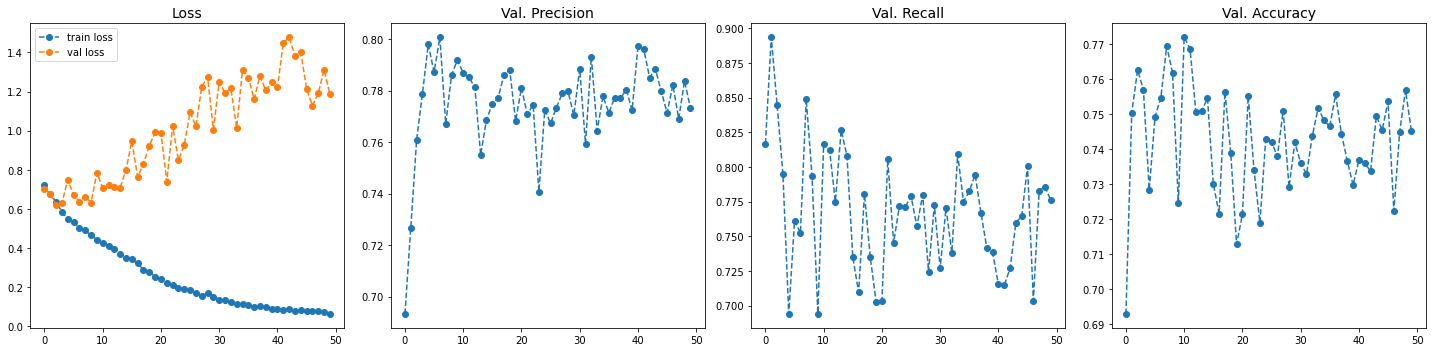

In [597]:
# ViTb32 pretrained 50 epochs, lr 1e-4, weight decay 1e-5
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].set_title('Loss', fontsize=14)
ax[0].plot(np.arange(epochs), train_losses, '--o', label='train loss')
ax[0].plot(np.arange(epochs), val_losses, '--o', label='val loss')
ax[0].legend()

ax[1].set_title('Val. Precision', fontsize=14)
ax[1].plot(np.arange(epochs), precision, '--o', label='precision')
# ax[1].set_ylim([0, 1])

ax[2].set_title('Val. Recall', fontsize=14)
ax[2].plot(np.arange(epochs), recall, '--o', label='recall')

ax[3].set_title('Val. Accuracy', fontsize=14)
ax[3].plot(np.arange(epochs), accuracy, '--o', label='accuracy')

plt.tight_layout()
plt.show()

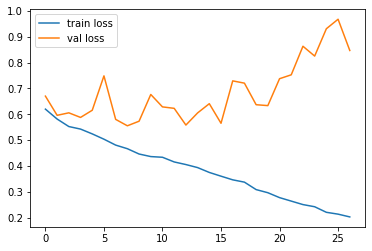

In [68]:
# DINOv2
plt.plot(np.arange(30)[:27], train_losses[:27], label='train loss')
plt.plot(np.arange(30)[:27], val_losses[:27], label='val loss')

plt.legend()
plt.show()

## Test and evaluate materics 

In [601]:
test_dir = '/sci/labs/dekel/oshri.fatkiev/vela3_6d_crop_64/images/test/'
test_dataset = Dataset(images_dir=test_dir, image_size=224, augment=False, 
                       transform=transform, norm_each_channel=False, prot=0, pud=0, plr=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)  

100%|██████████| 960/960 [00:05<00:00, 161.22it/s]


In [18]:
from torchvision.models import vit_b_32

model = vit_b_32()
model.conv_proj = nn.Conv2d(6, 768, kernel_size=(32, 32), stride=(32, 32))
model.heads.head = nn.Linear(in_features=768, out_features=1, bias=True)

model.to(device)

learning_rate = 1e-4
weight_decay = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

load_checkpoint(checkpoint_file="ViTb32_40epochs.pth.tar", model=model, optimizer=optimizer, lr=learning_rate, device=device)

>> Loading checkpoint...
Done loading checkpoint.



In [609]:
# lst = []
# with torch.no_grad():
#     for images, targets, _ in test_loader:
#         images, targets = images.to(device).float(), targets.to(device).float()
#         for i in range(len(images)):
#             logits = model(images[i].unsqueeze(0))
#             lst.append(torch.sigmoid(logits).cpu().float().item())

In [610]:
# plt.hist(lst, alpha=0.7)

In [611]:
with torch.no_grad():
    for images, targets, _ in test_loader:
        images, targets = images.to(device).float(), targets.to(device).float()
        for i in range(len(images)):
            # plt.imshow(images[i][0,...])
            outputs = model(images[i].unsqueeze(0))
            print((torch.sigmoid(outputs) > 0.5).item(), bool(targets[i]))


False False
False False
False False
False False
False True
True True
True True
True True
True True
False True
True True
True True
True True
False True
False True
True True
True False
True True
True True
True True
True True
True False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True False
True True
False False
False False
False False
False False
True True
True False
True True
True True
True True
True True
True True
False True
False True
True True
False True
False True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
False False
False False
False True
False False
True True
True True
True True
False True
True True
True True
True True
True True
False True
True Fals

True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
False False
False False
True True
False False
True True
True True
True True
True True
True True
True True
False True
True False
False True
True True
True False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
False False
False False
False True
False False
False True
True True
True True
True True
True True
True True
False True
False True
False True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
F

In [604]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
  
model.eval()

all_targets = []
all_predictions = []

with torch.no_grad():
    for images, targets, _ in tqdm(test_loader, leave=True, file=sys.stdout, colour='GREEN'):
        images, targets = images.to(device).float(), targets.to(device).float()

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()
        
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(y_true=all_targets, y_pred=all_predictions, normalize=True)
precision = precision_score(y_true=all_targets, y_pred=all_predictions)
recall = recall_score(y_true=all_targets, y_pred=all_predictions)
f1 = f1_score(y_true=all_targets, y_pred=all_predictions)
roc_auc = roc_auc_score(y_true=all_targets,y_score=all_predictions)

print(f'\nAccuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'ROC-AUC: {roc_auc:.3f}')

100%|██████████| 15/15 [00:02<00:00,  5.98it/s]

Accuracy: 0.868
Precision: 0.952
Recall: 0.890
F1 Score: 0.920
ROC-AUC: 0.813


100%|██████████| 15/15 [00:02<00:00,  5.84it/s]


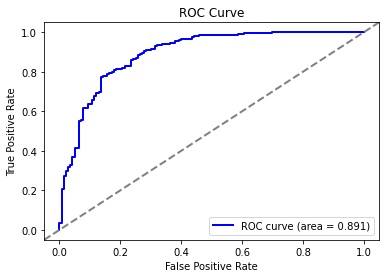

In [613]:
from sklearn.metrics import roc_curve, roc_auc_score

model.eval()

all_targets = []
all_probabilities = []

with torch.no_grad():
    for images, targets, _ in tqdm(test_loader, leave=True, file=sys.stdout, colour='GREEN'):
        images, targets = images.to(device).float(), targets.to(device).float()
        
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
    
        all_targets.extend(targets.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_targets = np.array(all_targets)
all_probabilities = np.array(all_probabilities)

fpr, tpr, thresholds = roc_curve(all_targets, all_probabilities)
roc_auc = roc_auc_score(all_targets, all_probabilities)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([-0.05, 1.05], [-0.05, 1.05], color='gray', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()